# Word2Vec

In [1]:
import pandas as pd
import numpy as np
import itertools
from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report
import optuna
import string
import os

In [2]:
# Load Data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Copy review column to 'text' (to match baseline format)
train_df["text"] = train_df["review"]
test_df["text"] = test_df["review"]

# Text Cleaning
stop_words = set(stopwords.words("english"))
translator = str.maketrans(string.punctuation, " " * len(string.punctuation))

def preprocess_text(text):
    """Removes punctuation, tokenizes, and removes stopwords."""
    text_nopunct = text.translate(translator)
    words_list = text_nopunct.strip().split()
    filtered_words = [word for word in words_list if word.lower() not in stop_words and len(word) > 1]
    return filtered_words

# Apply Preprocessing
train_df["text"] = train_df["text"].apply(preprocess_text)
test_df["text"] = test_df["text"].apply(preprocess_text)

In [3]:
# Build Vocabulary
tagged_data = train_df["text"].tolist()  # Convert text column to list of tokenized sentences
word_counts = Counter(itertools.chain(*tagged_data))
vocabulary_inv = [x[0] for x in word_counts.most_common()]
vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}

# Train Word2Vec Embeddings
embedding_model = Word2Vec(sentences=tagged_data, vector_size=100, window=5, min_count=2, workers=4)
embedding_weights = np.zeros((len(vocabulary_inv), 100))

for i, word in enumerate(vocabulary_inv):
    if word in embedding_model.wv:
        embedding_weights[i] = embedding_model.wv[word]
    else:
        embedding_weights[i] = np.random.uniform(-0.25, 0.25, 100)  # Assign random vector for unseen words

# Convert Sentences to Word Vectors
def get_sentence_vector(words):
    """Averages Word2Vec embeddings for words in a sentence."""
    vec = np.zeros(100)
    valid_words = [word for word in words if word in vocabulary]
    
    if len(valid_words) == 0:
        return vec  # Return zero vector if no valid words
    
    for word in valid_words:
        vec += embedding_weights[vocabulary[word]]
    
    return vec / len(valid_words)  # Average the vectors

# Create Train & Test Feature Matrices
X_train = np.array([get_sentence_vector(text) for text in train_df["text"]])
X_test = np.array([get_sentence_vector(text) for text in test_df["text"]])

# Encode Labels as Integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df["label"])

In [4]:
from sklearn.model_selection import GridSearchCV, train_test_split

# Split the training data for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)



In [11]:
train_df.dtypes

id                         int64
attributes.HappyHour      object
attributes.Ambience       object
hours.Tuesday             object
postal_code               object
                           ...  
attributes.GoodForMeal    object
hours                     object
label                     object
review                    object
text                      object
Length: 63, dtype: object

In [12]:
test_df.dtypes

id                         int64
attributes.HappyHour      object
attributes.Ambience       object
hours.Tuesday             object
postal_code               object
                           ...  
attributes.GoodForKids    object
attributes.GoodForMeal    object
hours                     object
review                    object
text                      object
Length: 62, dtype: object

# Logistic

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

In [26]:
# Load Data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Fill missing values
train_df["review"] = train_df["review"].fillna("")
test_df["review"] = test_df["review"].fillna("")

# Encode Labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df["label"])

# Compute Class Weights for Imbalanced Classes
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

tf-idf

In [30]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Optimized TF-IDF
tfidf = TfidfVectorizer(
    max_features=40000,  # More features = better representation
    stop_words="english",  # Prevents removing important words
    ngram_range=(1, 3),  # Uses unigrams, bigrams, trigrams
)

# Fit TF-IDF on train data and transform both train & test
X_train_text = tfidf.fit_transform(train_df["review"])
X_test_text = tfidf.transform(test_df["review"])

In [99]:


# **3️⃣ Compute Class Weights (No SMOTE, No Synthetic Data)**
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}


In [104]:
# **4️⃣ Tune Logistic Regression (Stronger Regularization)**
param_dist_logreg = {
    "C": np.logspace(-2, 2),  # ✅ Reduce number of `C` values
    "penalty": ["l2"],  # ✅ Use only L2 regularization (L1 & ElasticNet take longer)
    "solver": ["lbfgs"],  # ✅ "lbfgs" is much faster than "saga"
}

strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

cv_lr = RandomizedSearchCV(
    LogisticRegression(max_iter=5000, class_weight="balanced"),
    param_distributions=param_dist_logreg,
    n_iter=10,
    scoring="f1_weighted",
    cv=strat_k_fold,
    verbose=3,
    n_jobs=-1,
    refit=True,
    random_state=1234
)

# **5️⃣ Train Model on Optimized Features**
cv_lr.fit(X_train_text, y_train)

# **6️⃣ Print Best Hyperparameters**
print(f"Best Hyperparameters for Logistic Regression: {cv_lr.best_params_}")

# **7️⃣ Get Cross-Validation F1 Score**
print(f"Best Cross-Validation F1 Score: {cv_lr.best_score_:.4f}")

# **8️⃣ Perform Cross-Validation on Final Model**
cv_f1_scores = cross_val_score(cv_lr.best_estimator_, X_train_text, y_train, cv=5, scoring="f1_weighted")

print(f"Cross-Validation F1 Scores: {cv_f1_scores}")
print(f"Mean Cross-Validation F1 Score (After Fixes): {np.mean(cv_f1_scores):.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters for Logistic Regression: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 2.329951810515372}
Best Cross-Validation F1 Score: 0.8113
Cross-Validation F1 Scores: [0.80810499 0.80835394 0.81546542 0.8088744  0.80516052]
Mean Cross-Validation F1 Score (After Fixes): 0.8092


40000+tri
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters for Logistic Regression: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1.6681005372000592}
Best Cross-Validation F1 Score: 0.8111
Cross-Validation F1 Scores: [0.81029765 0.80725435 0.81484751 0.81173258 0.80379977]
Mean Cross-Validation F1 Score (After Fixes): 0.8096

param 2
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters for Logistic Regression: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 2.329951810515372}
Best Cross-Validation F1 Score: 0.8113
Cross-Validation F1 Scores: [0.80810499 0.80835394 0.81546542 0.8088744  0.80516052]
Mean Cross-Validation F1 Score (After Fixes): 0.8092

In [105]:
# **9️⃣ Predict on Test Set**
y_test_pred = cv_lr.best_estimator_.predict(X_test_text)

# **Convert Predictions Back to Original Labels**
test_predictions = label_encoder.inverse_transform(y_test_pred)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Cross-Validation F1 Scores: [0.80664348 0.80757936 0.81494534 0.81038033 0.80452157]
Mean Cross-Validation F1 Score: 0.8088

In [106]:


# **Save Predictions**
submission_df = pd.DataFrame({"Id": test_df["id"], "Predicted": test_predictions})
submission_df.to_csv("predictions.csv", index=False)
print("Predictions saved to predictions.csv")

Predictions saved to predictions.csv


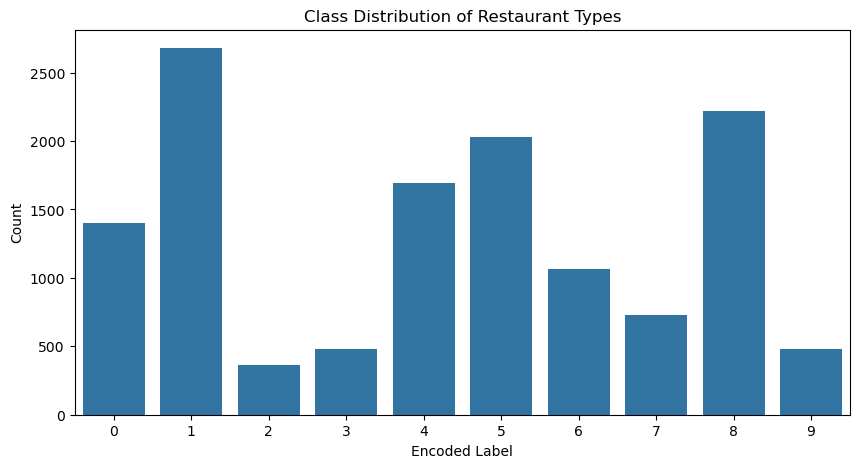

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count class distribution
label_counts = pd.Series(y_train).value_counts()

# Plot class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel("Encoded Label")
plt.ylabel("Count")
plt.title("Class Distribution of Restaurant Types")
plt.show()